In [67]:
import numpy as np
from numpy.lib import stride_tricks
import os
import librosa.display
import IPython.display
import pandas as pd
import scipy.io.wavfile as wav

# Data visualization
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [68]:
# Load data from the .npz file
real = np.load('/kaggle/input/footprints/Footprints Datasets/real.npz')
fake = np.load('/kaggle/input/footprints/Footprints Datasets/fake.npz')

In [69]:
X_real=real['x']
y_real=np.ones(750)
X_fake=fake['x']
y_fake=np.zeros(750)
X_real.shape,y_real.shape,X_fake.shape,y_fake.shape

((750, 1998, 101), (750,), (750, 1998, 101), (750,))

In [70]:
X=np.concatenate((X_real,X_fake),axis=0)
y=np.concatenate((y_real,y_fake),axis=0)
indices =np.arange(X.shape[0])
np.random.shuffle(indices)
X=X[indices]
y=y[indices]
indices

array([ 841, 1326,  993, ...,  306,  512,  204])

In [71]:
from sklearn.model_selection import train_test_split

In [72]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=0)

In [73]:
# handling with zero
non_inf_values_train = X_train[np.isfinite(X_train)]

X_train[np.isinf(X_train)] = float(0)
X_test[np.isinf(X_test)] = float(0)  

In [45]:
# X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=0)

In [74]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout, Flatten, Dense, BatchNormalization,Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
# from keras.applications import MobileNetV3Small

In [75]:
input_shape = (X_train.shape[1], X_train.shape[2], 1)
model = Sequential()
model.add(BatchNormalization(axis=1, input_shape=input_shape))
model.add(Conv2D(32, kernel_size=3, activation="relu", padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, kernel_size=3, activation="relu", padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, kernel_size=3, activation="relu", padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(128, kernel_size=3, activation="relu", padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(128, activation = 'relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation="sigmoid"))

/opt/conda/lib/python3.10/site-packages/keras/src/layers/normalization/batch_normalization.py:143: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [76]:
# Compile the model
model.compile(optimizer="Adam",
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [77]:
# Define filepath for saving the best model with .h5 extension
filepath = "best_model.keras"

# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

In [78]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ batch_normalization_2           │ (None, 1998, 101, 1)   │         7,992 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 1998, 101, 32)  │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 999, 50, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 999, 50, 64)    │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 499, 25, 64)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 499, 25, 64)    │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 249, 12, 64)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 249, 12, 128)   │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 124, 6, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 95232)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │    12,189,824 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,327,545 (47.03 MB)

 Trainable params: 12,323,549 (47.01 MB)

 Non-trainable params: 3,996 (15.61 KB)

In [79]:
history = model.fit(X_train, y_train,
                    epochs=30,
                    batch_size=128,
                    validation_data=(X_test, y_test),
                    callbacks=[early_stopping, checkpoint])

Epoch 1/30


W0000 00:00:1709661561.301470     114 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.5509 - loss: 0.8069   

W0000 00:00:1709661620.495368     111 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update



Epoch 1: val_loss improved from inf to 0.59136, saving model to best_model.keras
11/11 ━━━━━━━━━━━━━━━━━━━━ 65s 6s/step - accuracy: 0.5524 - loss: 0.8030 - val_accuracy: 0.7467 - val_loss: 0.5914
Epoch 2/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 587ms/step - accuracy: 0.7589 - loss: 0.5762
Epoch 2: val_loss did not improve from 0.59136
11/11 ━━━━━━━━━━━━━━━━━━━━ 7s 616ms/step - accuracy: 0.7610 - loss: 0.5713 - val_accuracy: 0.8133 - val_loss: 0.6290
Epoch 3/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 585ms/step - accuracy: 0.8640 - loss: 0.3509
Epoch 3: val_loss improved from 0.59136 to 0.33644, saving model to best_model.keras
11/11 ━━━━━━━━━━━━━━━━━━━━ 8s 684ms/step - accuracy: 0.8658 - loss: 0.3468 - val_accuracy: 0.9133 - val_loss: 0.3364
Epoch 4/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 588ms/step - accuracy: 0.9269 - loss: 0.1877
Epoch 4: val_loss improved from 0.33644 to 0.26602, saving model to best_model.keras
11/11 ━━━━━━━━━━━━━━━━━━━━ 8s 685ms/step - accuracy: 0.9274 - loss: 0.1864 - val_accuracy: 0.9

In [52]:
X_test.shape,y_test.shape

((150, 1998, 101), (150,))

In [80]:
loss, accuracy = model.evaluate(X_test, y_test)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - accuracy: 1.0000 - loss: 6.9934e-04
Test Loss: 0.0007344451732933521
Test Accuracy: 1.0


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 133ms/step


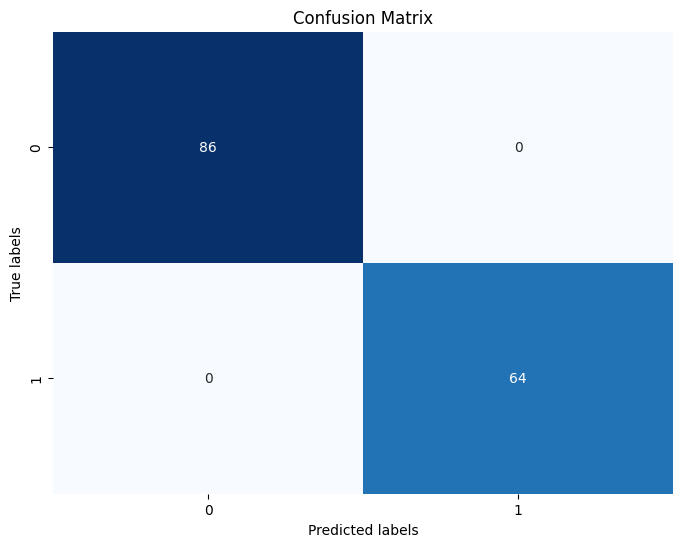

Precision: 1.00
Recall: 1.00


In [81]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score

# Assuming y_test is the true labels for your test data
y_pred = (model.predict(X_test) >= 0.5).astype(int).flatten()

# Compute precision and recall
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

# Generate confusion matrix
conf_mat = confusion_matrix(y_test, y_pred)

# Plot heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_mat, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")


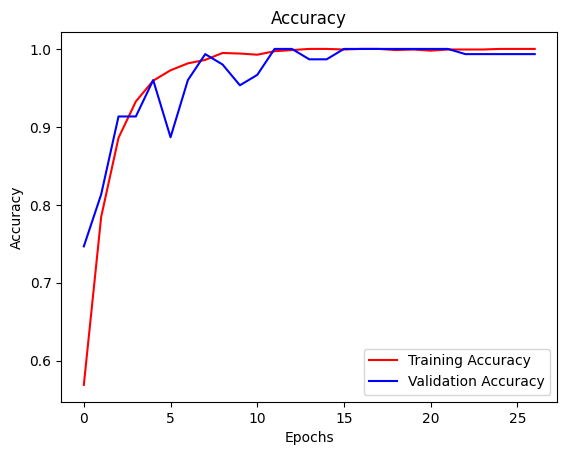

In [82]:
plt.title('Accuracy')
plt.plot(history.history['accuracy'], 'r', label='Training Accuracy')
plt.plot(history.history['val_accuracy'], 'b', label='Validation Accuracy')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

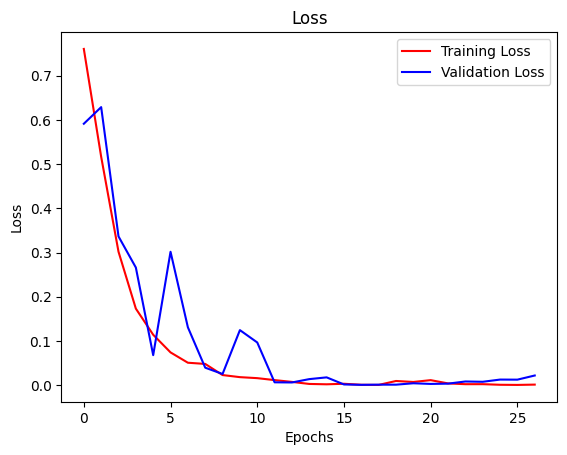

In [83]:
plt.title('Loss')
plt.plot(history.history['loss'], 'r', label='Training Loss')
plt.plot(history.history['val_loss'], 'b', label='Validation Loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

In [84]:
def image_preprocessing(image):
    non_inf_values = image[np.isfinite(image)]
    image[np.isinf(image)] = float(0)
    image = np.expand_dims(image, axis=0)
    return image

In [85]:
def data_preprocessing(image):
    non_inf_values = image[np.isfinite(image)]
    image[np.isinf(image)] = float(0)
    return image

In [86]:
X_fake_data=data_preprocessing(X_fake)

In [87]:
y_pred = (model.predict(X_fake_data) >= 0.6).astype(int).flatten()

24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step


In [88]:
sum(y_pred==1)

0

In [62]:
from keras.models import load_model

# Load the model
best = load_model('/kaggle/working/best_model.keras')
trying = (best.predict(X_test) >= 0.5).astype(int).flatten()

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 110ms/step


In [63]:
sum(trying==y_test)

149